# Linear Models in Machine Learning on Python - Logistic Regression 4

Welcome to the last notebook about Logistic Regression. In the last notebook on Logistic Regression I will do two examples, one for binary classification and the other one is for multiclass classification. In the binary classification example, I will use the weather dataset that we used in the second notebook, but this time I will try to deal with class imbalance, by extension of that, I will try to improve the performance. In the second example, I will use a new dataset and introduce some new cross validation functions.

## Binary Classification with Logistic Regression

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
import warnings
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore', module='sklearn')
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

Let's load our dataset.

In [2]:
data=pd.read_csv("weatherAUS.csv")
data.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


I will define the function that I utilized in the second notebook and then transform the data.

In [3]:
def splitdate(data_s):
    data_s["Date"] = pd.to_datetime(data_s["Date"]) #convert it to date
    data_s["Year"]=data_s["Date"].dt.year # Parsing year 
    data_s["Month"]=data_s["Date"].dt.month # Parsing month
    data_s["Day"]=data_s["Date"].dt.day # Parsing day
    data_s =  data_s.drop(["Date"], axis=1) # Dropping original Date row
    return data_s;

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

class Convert_Missing(BaseEstimator, TransformerMixin):
    def __init__(self,data): # no *args or **kargs
        print("Transforming in progress...")
        self.data=data;
        self.splitted_data=splitdate(data);
        self.categorical = [features for features in self.splitted_data.columns if self.splitted_data[features].dtype==object]
        self.numerical = [features for features in self.splitted_data.columns if self.splitted_data[features].dtype==float]
        self.numerical_int64 = [features for features in self.splitted_data.columns if self.splitted_data[features].dtype=='int64']
    def transform(self):
        imputer = SimpleImputer(strategy="most_frequent")
        features_categorical=imputer.fit_transform(self.splitted_data[self.categorical])
        imputer = SimpleImputer(strategy="median")
        features_numeric=imputer.fit_transform(self.splitted_data[self.numerical])
        concatenated_array=np.concatenate((features_categorical,features_numeric),axis=1)#concatane arrays obtained from imputer
        dataframe=pd.DataFrame(concatenated_array, columns=self.categorical+self.numerical) # convert it to dataframe
        frames = [dataframe, data[self.numerical_int64]] # combining the dataframe in the previous line and date dataframe 
        final_dataframe=pd.concat(frames,axis=1)  # concataneting the two dataframes in the previous line
        final_dataframe=final_dataframe.loc[:,~final_dataframe.columns.duplicated()]
        print("Transforming completed")
        return final_dataframe

In [5]:
le=LabelEncoder()
def One_Hot_Encoder(data):
    numerical = [features for features in data.columns if data[features].dtype==float]  # getting names of numerical columns
    categorical = [features for features in data.columns if data[features].dtype==object] # getting names of categorical columns
    numerical_int64 = [features for features in data.columns if data[features].dtype=='int64']
    data=pd.concat([data[numerical],data[categorical],data[numerical_int64],pd.get_dummies(data.Location), 
                     pd.get_dummies(data.WindGustDir),
                     pd.get_dummies(data.WindDir9am),
                     pd.get_dummies(data.WindDir3pm)],axis=1)
    data["RainToday"]=le.fit_transform(data["RainToday"])
    data.drop(['Location','WindGustDir','WindDir9am','WindDir3pm'],axis=1,inplace=True)
    return data;

In [6]:
def scaleandmerge(data):
    
    scaler = StandardScaler()
    numerical_data = scaler.fit_transform(data[numerical])
    numerical_data = pd.DataFrame(numerical_data, columns=[numerical])
    data.drop(numerical,axis=1,inplace=True)
    data_processed=pd.concat([numerical_data, data],axis=1) 
    return data_processed

In [7]:
def combinedprocessing(data):
    missing_transformer=Convert_Missing(data)
    data1=missing_transformer.transform()
    data2=One_Hot_Encoder(data1)
    data3=scaleandmerge(data2)
    return data3;

In [8]:
numerical = [features for features in data.columns if data[features].dtype==float]
data_processed=combinedprocessing(data)

Transforming in progress...
Transforming completed


There is one important processing step that we need to do. When we are applying OneHotEncoding we also create some columns with the same name. This is not actually because of OneHotEncoding but because of the features that we encode have common values.

In [9]:
def df_column_uniquify(df):
    df_columns = df.columns
    new_columns = []
    for item in df_columns:
        counter = 0
        newitem = item
        while newitem in new_columns:
            counter += 1
            newitem = "{}_{}".format(item, counter)
        new_columns.append(newitem)
    df.columns = new_columns
    return df

In [10]:
data_processed=df_column_uniquify(data_processed)

Now let's use train_test_split() function on processed data and encode our target feature with LabelEncoder().

In [11]:
from sklearn.model_selection import train_test_split
le=LabelEncoder()
target=le.fit_transform(data_processed["RainTomorrow"])
data_processed.drop(["RainTomorrow"],axis=1,inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data_processed, target, test_size = 0.2, random_state = 42)

## Dealing with Class Imbalance

We are done with transforming the data, now let's again look at the class imbalance in our target feature.

C:\Users\gorke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

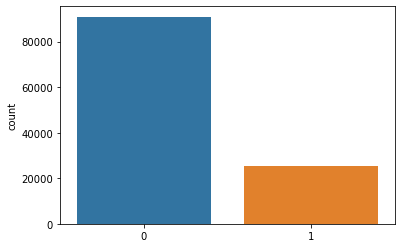

In [12]:
sns.countplot(y_train)

In this part I will talk about one of the ways to deal with class imbalance, resampling. There are other ways and we actually used some of them before(such as adding class weight to classifier). However, resampling is a more general step for dealing with class imbalance compared to other methods that we used previously. If you would like to learn more about other ways to deal with class imbalance you can use check the [link](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) 

 
In order to deal with class imbalance we can resample our dataset in two ways, we can either remove samples from the majority class (that is called undersampling) or we can add more examples from the minority class (that is called oversampling). There are different algorithms to oversample or undersample. In this part I will talk about some of them and train a model to select which of these techniques works best for our dataset. In the end I will share a depository that you can find more about these techniques and other techniques that you can use to resample. On the other hand, before starting, I would like to share an article about Statistical Sampling. It's an important concept to learn I think so that one can understand the importance of stratifiedsampling and sampling error, this article will be a good introduction for you [link](https://machinelearningmastery.com/statistical-sampling-and-resampling/)

### Random Undersampling

The first approach that I will use for resampling is Random Undersampling. As name suggests, we will randomly select some instances from the dataset and then delete them.

In [13]:
from imblearn.under_sampling import RandomUnderSampler

In [14]:
undersampler = RandomUnderSampler(sampling_strategy='majority',random_state=42)

One important parameter that we will use for resampling functions is **sampling_strategy**. When we pass majority, it means that we want to reduce the majority class to the size of minority class.

In [15]:
undersampler_float = RandomUnderSampler(sampling_strategy=0.7,random_state=42)

We can also set the sampling_strategy to a floating point value. In this case we are actually setting a percantage. For example, setting the argument to 0.3 will cause our our majority class to have %30 more instances than the minority class.

In [16]:
X_rusmajority,yrusmajority = undersampler.fit_resample(X_train,y_train)

C:\Users\gorke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

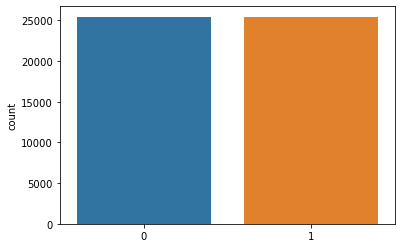

In [17]:
sns.countplot(yrusmajority)

Let's also use the second RandomUnderSampler() that we defined.

In [18]:
X_rusfloat, yrusfloat = undersampler_float.fit_resample(X_train,y_train)

C:\Users\gorke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

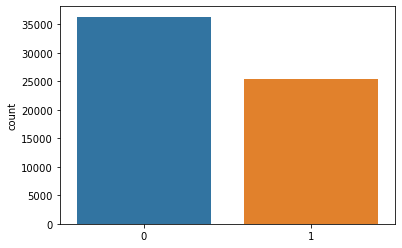

In [19]:
sns.countplot(yrusfloat)

You probably noticed that I only resample the training set. To understand why, read the discussion [link](https://datascience.stackexchange.com/questions/57882/resampling-for-imbalaced-datasets-should-testing-set-also-be-resampled)

### Random Oversampling

I will do almost the exact same steps that I did above, with a little difference. This time I will set sampling_strategy to minority since we are randomly oversampling (copying random instances) the minority class.

In [20]:
from imblearn.over_sampling import RandomOverSampler

In [21]:
oversampler = RandomOverSampler(sampling_strategy='minority',random_state=42)

In [22]:
oversampler_float = RandomOverSampler(sampling_strategy=0.4,random_state=42)

In [23]:
X_rosmajority,yrosmajority = oversampler.fit_resample(X_train,y_train)

C:\Users\gorke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

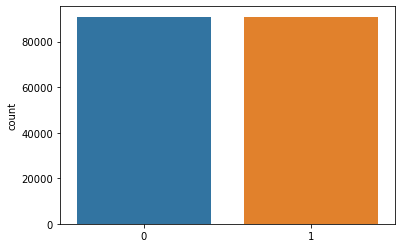

In [24]:
sns.countplot(yrosmajority)

In [25]:
X_rosfloat, yrosfloat = oversampler_float.fit_resample(X_train,y_train)

C:\Users\gorke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

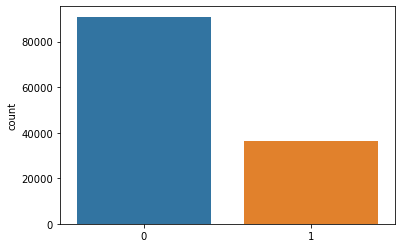

In [26]:
sns.countplot(yrosfloat)

Documentation for `RandomOverSampler()` [link](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html)


Documentation for `RandomUnderSampler()` [link](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html)

Also I do recommend reading this article on machine learning mastery [link](https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/)

### Synthetic Minority Oversampling Technique (SMOTE)

One of the main problems of randomly sampling is it doesn't provide much additional information to the model. We are simply adding copies of the some random instances. Instead, we can use an algorithm called SMOTE that synthetically creates new instance in the minority class. The algorithm uses an approach that is very similar to a machine learning algorithm called K-Means, I will not go into details but I will share some sources where you can find the algorithm of the function (It's actually pretty easy).

1. MachineLearningMastery article for SMOTE [link](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

2. This article has a good explanation for SMOTE and other resampling methods [link](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

In [27]:
from imblearn.over_sampling import SMOTE

The algorithm has almost the same parameters as `RandomOverSampler()` or `RandomUnderSampler()` except that the parameter **k_neighbors**. Briefly, while creating new samples the algorithm randomly picks an instance and then find closest instances to the selected one, then creates new instances between them. The parameter k_neighbors defines the distance that our algorithm uses for finding closest instances. For example, when it is set to 5 the algorithm find the closes five instances to create new ones between them. For learning more about this function check out the documentation [link](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)

In [28]:
oversample = SMOTE(sampling_strategy=0.7,k_neighbors=50)
X_smote, y_smote = oversample.fit_resample(X_train,y_train)

C:\Users\gorke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

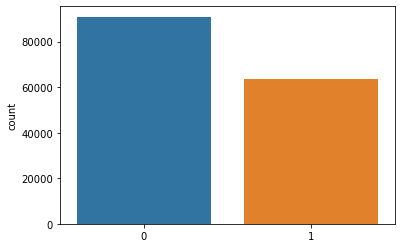

In [29]:
sns.countplot(y_smote)

### SMOTE with Undersampling

In [30]:
from imblearn.pipeline import Pipeline
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

Notice that we have a different pipeline in this case.

In [31]:
X_smote_rus, y_smote_rus = pipeline.fit_resample(X_train, y_train)

C:\Users\gorke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

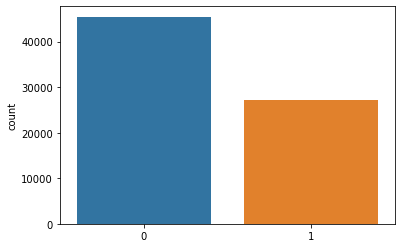

In [32]:
sns.countplot(y_smote_rus)

## Feature Selection

When we look at the dataframe it's obvious that we have lots of features. There's an important processing step that we didn't talk about before, it's feature selection. I will talk about feature selection more when we start learning Support Vector Machines, however, let's now use a function that simply selects important features for us. Here I will use an algorithm called Recursive Feature Elimination, RFE in short. For using this algorithm we will use `RFE()` function in sklearn, and pass the machine learning algorithm that we will use in addition to number of features that we want. You can find a detailed explanation for the function on MachineLearningMastery [link](https://machinelearningmastery.com/rfe-feature-selection-in-python/) also don't forget to check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

Firstly, let's define RFE.

In [36]:
from sklearn.feature_selection import RFE
RFE_feaselector = RFE(estimator=LogisticRegression(C=1,fit_intercept=True, penalty="l2", warm_start=True,class_weight="balanced"),n_features_to_select= 40)


Now I will use `fit()` method on X_train and y_train

In [37]:
rfe = RFE_feaselector.fit(X_train,y_train)

After fitting, use `get_support()` method to get which columns to use.

In [38]:
selected_columns = rfe.get_support(1)
dataset_reduced = X_train[X_train.columns[selected_columns]] # reducing the size of datasets

In [39]:
def feature_selector(x,y):
    rfe = selector.fit(x,y)
    selected_columns = rfe_model.get_support(1)
    dataset_reduced = X_train[X_train.columns[selected_columns]]

We are ready to train our models on the processed data.

## Training Logistic Regression

I will use `GridSearchCV()` on every resampled X_train and y_train. I will do that using a for loop and for every model I will save performance metrics and best parameters.

Let's firstly convert our training sets into a form that we can loop through.

In [40]:
datasets={1:[X_rusmajority,yrusmajority],
         2:[X_rusfloat, yrusfloat],
         3:[X_rosmajority,yrosmajority],
         4:[X_rosfloat, yrosfloat],
         5:[X_smote, y_smote],
         6:[X_smote_rus, y_smote_rus]}

In [41]:
logreg=LogisticRegression()

In [42]:
params = {
    'C':[100, 10, 1.0, 0.1, 0.01],
    'l1_ratio': [0.25,0.50, 0.75, 0.90],
    'penalty': ["l2","l1","elasticnet"],
    'fit_intercept':[True,False],
    'warm_start':[True,False],
    
}

In [43]:
from sklearn.model_selection import GridSearchCV
gscv=GridSearchCV(logreg, params, cv=10,verbose=2,scoring="f1")

Now let's fit our model for every dataset variants we have.

In [ ]:
f1_scores=[]
accuracy_scores=[]
best_parameters=[]
for i in datasets:
    
    model=gscv.fit(datasets[i][0], datasets[i][1])
    f1_scores.append(f1_score(y_test, model.predict(X_test)))
    accuracy_scores.append(accuracy_score(y_test, model.predict(X_test)))
    best_parameters.append(model.best_params_)

In [45]:
accuracy_scores

[0.7833424996562629,
 0.8129382648150695,
 0.7842362161418946,
 0.837206104771071,
 0.8159631513818232,
 0.8169943627113984]

In [46]:
f1_scores

[0.6098904499597697,
 0.6184265881363064,
 0.609372082892526,
 0.5993231810490692,
 0.6099941724941724,
 0.6045164165800029]

Looks like we improved the metrics slightly.

In [47]:
best_parameters

[{'C': 100,
  'fit_intercept': False,
  'l1_ratio': 0.25,
  'penalty': 'l2',
  'warm_start': True},
 {'C': 0.1,
  'fit_intercept': True,
  'l1_ratio': 0.25,
  'penalty': 'l2',
  'warm_start': True},
 {'C': 0.1,
  'fit_intercept': True,
  'l1_ratio': 0.25,
  'penalty': 'l2',
  'warm_start': True},
 {'C': 0.01,
  'fit_intercept': False,
  'l1_ratio': 0.25,
  'penalty': 'l2',
  'warm_start': True},
 {'C': 100,
  'fit_intercept': False,
  'l1_ratio': 0.25,
  'penalty': 'l2',
  'warm_start': True},
 {'C': 100,
  'fit_intercept': True,
  'l1_ratio': 0.25,
  'penalty': 'l2',
  'warm_start': True}]

We are done with Binary Classification but before getting on with Multiclass example I just want to share some important websites in which you can find more about resampling.

1. Github page of imblearn liberary: You can find names of other algorithms that you can use for resampling [link](https://github.com/scikit-learn-contrib/imbalanced-learn)
2. A very good article about how SMOTE works [link](https://towardsdatascience.com/introduction-to-synthetic-minority-over-sampling-technique-and-its-implementation-from-scratch-77593647c10d). Moreover, you can also directly read the paper on SMOTE. I don't generally prefer sharing research papers but this one is pretty easy I think, especially if you read the article on Medium you won't probably have much trouble reading this [paper](https://arxiv.org/pdf/1106.1813.pdf).
3. Also don't forget to check this article from MachineLearningMastery [link](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)

# Multiclass Classification

I was thinking of using a dataset in which we can practice preprocessing but I don't want to keep this notebook very long. Therefore, we will continue with a well-known toy dataset IRIS Flower.

In [49]:
from sklearn import datasets

Let's load the dataset and examine for class imbalance.

In [50]:
iris = datasets.load_iris()

In [51]:
predictors=pd.DataFrame(iris.data, columns=[iris.feature_names])
target=iris.target

C:\Users\gorke\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

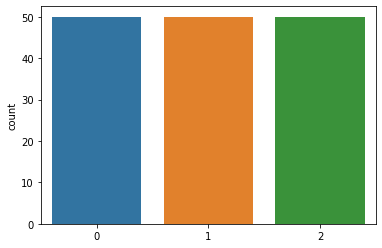

In [52]:
sns.countplot(target)

Looks like we have no problem with class imbalance. Before going on with constructing our LogisticRegression model, I will show two important cross validation functions: `RepeatedKFold()` and `LeaveOneOut()`.

## Cross Validation

Let's get started with `RepeatedKFold()`. The function involves a basic procedure, instead of using KFold cross validation for one time here we repeat the general KFold() cross validation procedure several times. Afterwards, the function generate overall prediction error by taking mean of the prediction error for every repeat. 


Another cross validation function that we will use is `LeaveOneOut()`. This algorithm trains repeatedly the model on all the instances except one and then use the omitted instance for prediction in test dataset. In other words, For n number of instances we train n number of models and each time leave out one instance for test set to predict. You can directly guess that using LeaveOneOut() strategy takes time because we train as much number of models as there are in our dataset.

I recommend reading MachineLearningMastery articles on both of these functions: [LeaveOneOut](https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/) and [RepeatedKFold](https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/)

In [53]:
from sklearn.model_selection import RepeatedKFold
repeated_kfold = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

The function above means that we will have 5 folds in each run and 15 in total. For every repeat, we shuffle the dataset and create 5 non-overlapping folds to use KFold cross validation.

In [54]:
from sklearn.model_selection import LeaveOneOut
loocv=LeaveOneOut()

In [55]:
logreg=LogisticRegression()

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size = 0.2, random_state = 42)

Let's now define our GridSearchCV parameters. I will use almost the same parameters above for tuning except that I will also use **multi_class** parameter since we can use both one-vs-all and multinomial versions of Logistic Regression.

In [57]:
params = {
    'C':[100, 10, 1.0, 0.1, 0.01],
    'l1_ratio': [0.25,0.50, 0.75, 0.90],
    'penalty': ["l2","l1","elasticnet"],
    'multi_class':["ovr", "multinomial"],
    'fit_intercept':[True,False],
    'warm_start':[True,False],
    
}

Now I will create three models and use three different cross validation.

In [58]:
gscv=GridSearchCV(logreg, params, cv=5,verbose=10,scoring="accuracy")#StratifiedKFold

In [ ]:
model1=gscv.fit(X_train,y_train)

In [60]:
model1.best_params_

{'C': 100,
 'fit_intercept': False,
 'l1_ratio': 0.25,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'warm_start': True}

In [61]:
accuracy_score(gscv.predict(X_test),y_test)

0.9333333333333333

Now I will use a function to estimate elapsed time in GridSearchCV. I took this function from a stackoverflow discussion [link](https://datascience.stackexchange.com/questions/29495/how-to-estimate-gridsearchcv-computing-time)

In [62]:
def calculate_time(gscv):
    mean_fit_time= gscv.cv_results_['mean_fit_time']
    mean_score_time= gscv.cv_results_['mean_score_time']
    n_splits  = gscv.n_splits_ #number of splits of training data
    n_iter = pd.DataFrame(gscv.cv_results_).shape[0] #Iterations per split
    return print(np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter)


In [63]:
calculate_time(gscv)

19.51252245903015


When we use StratifiedKFold with k=5, it more or less takes 18 seconds to complete the training. I tried to calculate the elapsed time by myself and it was around 20 seconds. I don't know actually why there is a difference but we can say that this calculate_time() function will show relatively the computing time difference between cross validation functions.

Let's go on with `RepeatedKFold()`.

In [64]:
gscv=GridSearchCV(logreg, params, cv=repeated_kfold,verbose=10,scoring="accuracy")

In [ ]:
model2=gscv.fit(X_train,y_train)

In [66]:
model2.best_params_

{'C': 10,
 'fit_intercept': True,
 'l1_ratio': 0.25,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'warm_start': True}

In [67]:
accuracy_score(gscv.predict(X_test),y_test)

1.0

In [68]:
calculate_time(gscv)

57.550904989242554


Let's use Leave-One-Out strategy.

In [69]:
gscv=GridSearchCV(logreg, params, cv=loocv,verbose=10,scoring="accuracy")

In [ ]:
model3=gscv.fit(X_train,y_train)

In [71]:
model3.best_params_

{'C': 10,
 'fit_intercept': True,
 'l1_ratio': 0.25,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'warm_start': True}

In [72]:
accuracy_score(gscv.predict(X_test),y_test)

1.0

In [73]:
calculate_time(gscv)

451.28929090499884


Let's use `onefunctiontoplothemall()` that we defined in the previous notebook to plot the performance curves for the trained models.

In [74]:
from sklearn.preprocessing import label_binarize

In [75]:
def onefunctiontoplothemall(y_predicted,y,plot_type):
    fpr = dict()
    tpr = dict()
    th  = dict()
    roc_auc = dict()
    
    y_score=label_binarize(y_predicted, classes=[0, 1, 2])
    y_test_binarized=label_binarize(y, classes=[0, 1, 2])
    n_classes = y_score.shape[1] 
    
    if(plot_type=="microavg_roc"):
        
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        plt.figure(figsize=(10, 7))
        # Plot ROC curve
        sns.set_style("darkgrid")
        plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["micro"]))
        sns.lineplot(x=[0, 1], y=[0, 1],label="No skill classifier",linestyle="dashed")
        plt.xlabel("Fall-out",fontsize=20)
        plt.ylabel("Recall",fontsize=20)
        plt.legend(loc="lower right",prop={'size': 16})
    
    
    if(plot_type=="roc"):
        plt.figure(figsize=(10, 7))
        # Plot ROC curve
        sns.set_style("darkgrid")
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))
            

        sns.lineplot(x=[0, 1], y=[0, 1],label="No skill classifier",linestyle="dashed")    
        plt.xlim([-0.05, 1.0])
        plt.ylim([-0.05, 1.05])
        plt.xlabel("Fall-out",fontsize=20)
        plt.ylabel("Recall",fontsize=20)
        plt.legend(loc="lower right",prop={'size': 16})

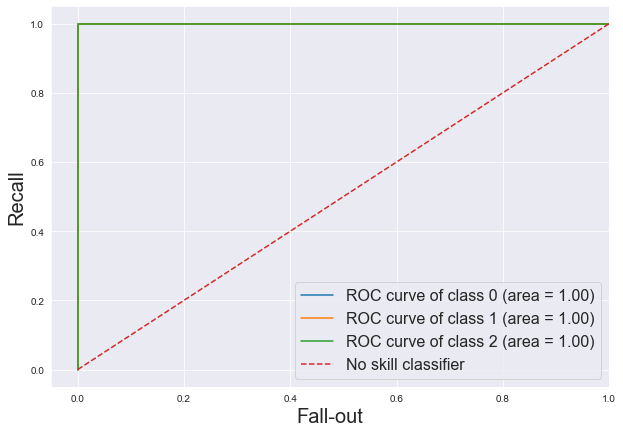

In [76]:
onefunctiontoplothemall(gscv.predict(X_test),y_test,"roc")

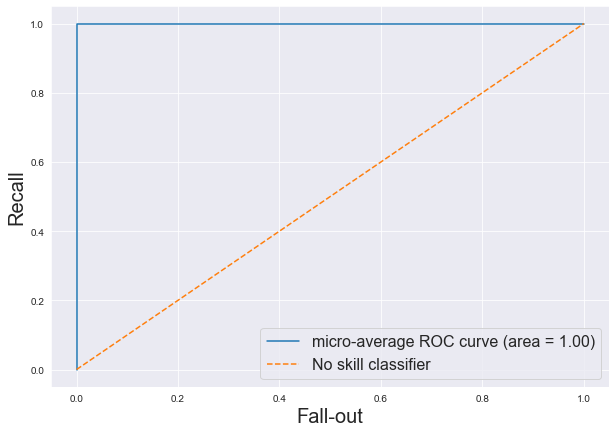

In [77]:
onefunctiontoplothemall(gscv.predict(X_test),y_test,"microavg_roc")

We are almost end of the LogisticRegression notebooks. I would like to talk about some cross validation functions that are originated from the ones that we used in this notebook. I will not use them here but I recommend you to do that. I will be probably using them in the upcoming notebooks.

1. RepeatedStratifiedKFold: This function is the combination of RepeatedKFold and StratifiedKFold. It performs RepeatedKFold algorithm and make sures that the folds are representative of the general population. Check out the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html)
2. LeavePOut: We saw that the funtion `LeaveOneOut()` leave out one instance for test set in each iteration. On the other hand, LeavePOut leaves P number of instance for test dataset in each iteration. This function doesn't create non-overlapping folds unlike LeaveOneOut. Check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html)

Lastly, check the user guide of sklearn for Cross Validation functions. There are some functions that I didn't show such as `GroupKFold()` (It makes sures that instance in testing and training folds are different as well as all the test folds are different from each other). I do recommend checking the [documentation](https://scikit-learn.org/stable/modules/cross_validation.html)